In [1]:
import os
import datetime
from dateutil.relativedelta import relativedelta
import requests
import zipfile
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import pacf
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import r2_score, mean_squared_error

%matplotlib inline

In [2]:
df = pd.read_csv('/Users/guapofish/Desktop/data_qi.csv')
df = df.set_index('Date')

df.index = pd.to_datetime(df.index, format='%Y%m%d', errors='ignore')
df.head()

,Signal,ClosePrice
Date,,
2012-01-03,3.107767,127.495
2012-01-04,3.107282,127.700
2012-01-05,3.099757,128.040
2012-01-06,3.134223,127.710
2012-01-09,3.135922,128.020


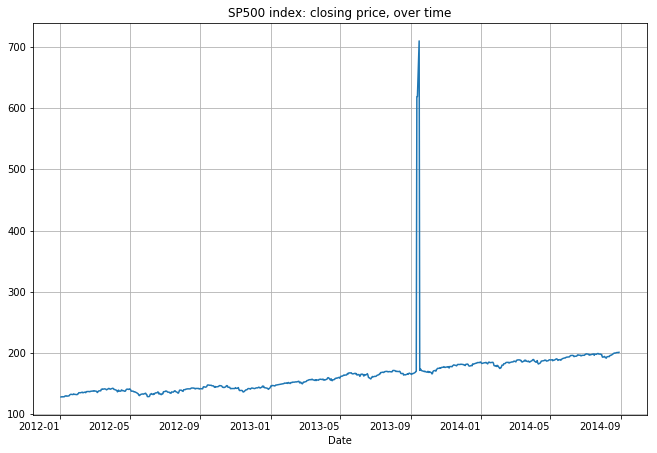

In [3]:
ax = df.ClosePrice.plot(figsize=(11, 8), rot=0)
g = ax.grid(True)
t = ax.title.set_text("SP500 index: closing price, over time")

In [4]:
# Scale the data, and drop the outlier 
df['Z_score_price'] = (df.ClosePrice - df.ClosePrice.mean())/df.ClosePrice.std(ddof=0)

In [5]:
df_adjust = df[abs(df['Z_score_price']) <= 3]

In [6]:
df.shape, df_adjust.shape

((667, 3), (664, 3))

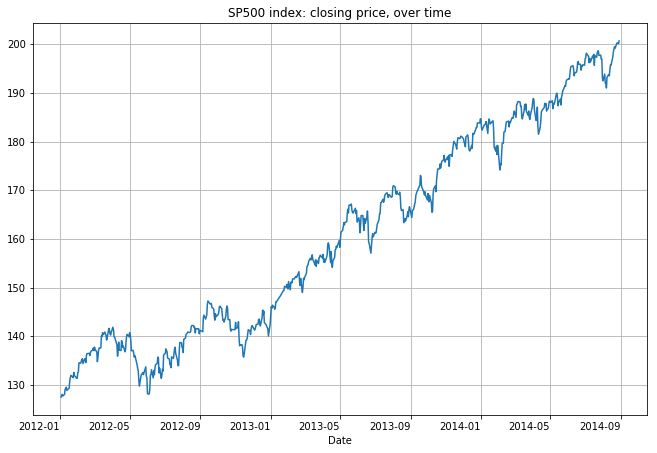

In [7]:
ax = df_adjust.ClosePrice.plot(figsize=(11, 8), rot=0)
g = ax.grid(True)
t = ax.title.set_text("SP500 index: closing price, over time")

In [8]:
df_adjust["return_daily"] = df_adjust.ClosePrice.pct_change()
df_adjust = df_adjust.dropna()
df_adjust['Z_score_return'] = (df_adjust.return_daily - df_adjust.return_daily.mean())/df_adjust.return_daily.std(ddof=0)

df_adjust.head()

/Users/guapofish/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,Signal,ClosePrice,Z_score_price,return_daily,Z_score_return
Date,,,,,
2012-01-04,3.107282,127.70,-0.905270,0.001608,0.122425
2012-01-05,3.099757,128.04,-0.896592,0.002662,0.266454
2012-01-06,3.134223,127.71,-0.905015,-0.002577,-0.449165
2012-01-09,3.135922,128.02,-0.897103,0.002427,0.234343
2012-01-10,3.143447,129.13,-0.868773,0.008671,1.086990


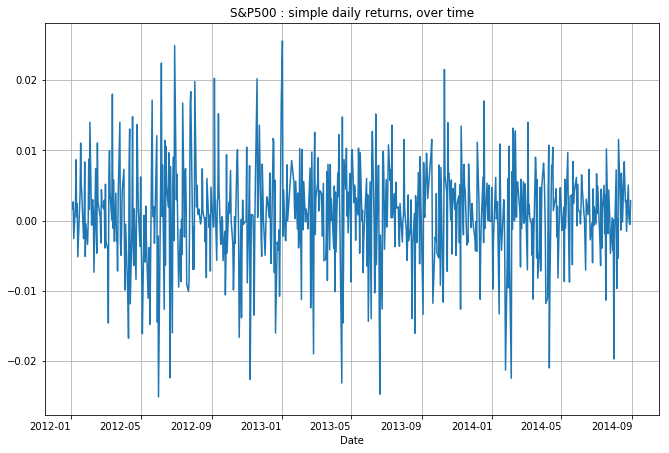

In [9]:
ax = df_adjust.return_daily.plot(figsize=(11, 8), rot=0)
g = ax.grid(True)
t = ax.title.set_text("S&P500 : simple daily returns, over time")

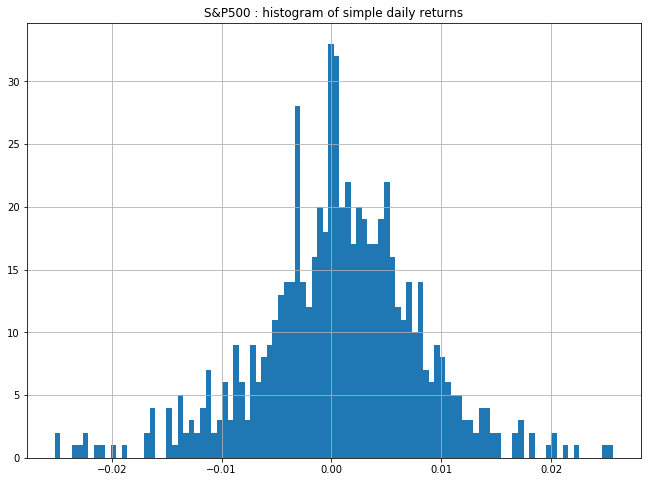

In [10]:
ax = df_adjust.return_daily.hist(bins=100, figsize=(11, 8))
g = ax.grid(True)
t = ax.title.set_text("S&P500 : histogram of simple daily returns")

# Check autocorelation

In [11]:

df_adjust.return_daily.rename("t"
                   ).to_frame(
                   ).join(
                        df_adjust.return_daily.shift(1).rename("t-1")
                   ).corr()

,t,t-1
t,1.00000,-0.01395
t-1,-0.01395,1.00000


In [12]:
# check autocorelation
df_adjust.return_daily.rename("t"
                   ).to_frame(
                   ).join(
                        df_adjust.return_daily.shift(1).rename("t-1")
                   ).corr().iloc[0, 1]

-0.013949841496477855

# Monthly Returns

In [13]:
df_adjust["year"] = df_adjust.index.year
df_adjust["month"] = df_adjust.index.month
df_adjust["return_daily_gross"] = df_adjust.return_daily + 1

In [14]:
df_monthly = df_adjust.groupby(["year", "month"]).return_daily_gross.prod()

In [15]:
df_monthly.shape

(32,)

In [16]:
df_monthly = df_monthly.rename("return_t")

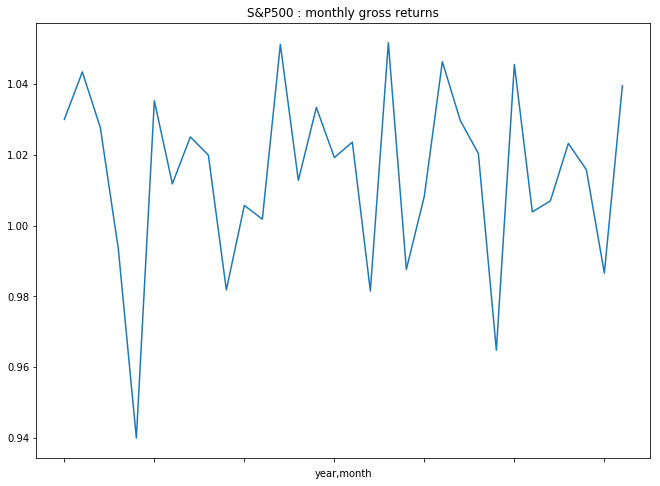

In [17]:
ax = df_monthly.plot(figsize=(11, 8))
t = ax.set_title("S&P500 : monthly gross returns")

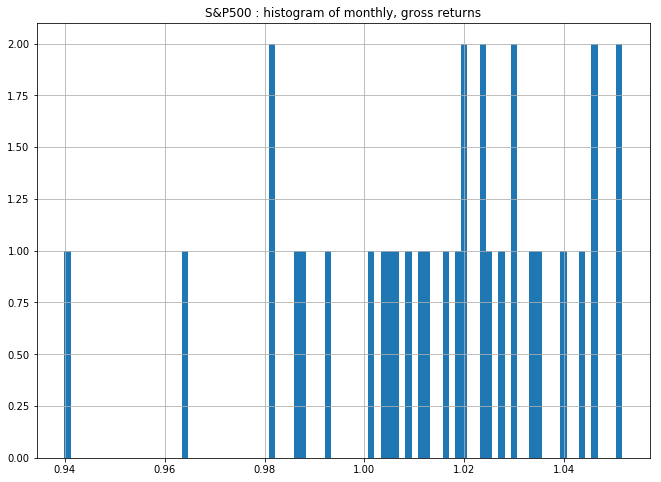

In [19]:
ax = df_monthly.hist(bins=90, figsize=(11, 8))
t = ax.title.set_text("S&P500 : histogram of monthly, gross returns")

In [21]:
df_monthly = df_monthly.to_frame()

# Rolling
-- Using the rolling method, we can create a rolling window of variable 
lengths over our data, and we can apply different sorts of aggregations.

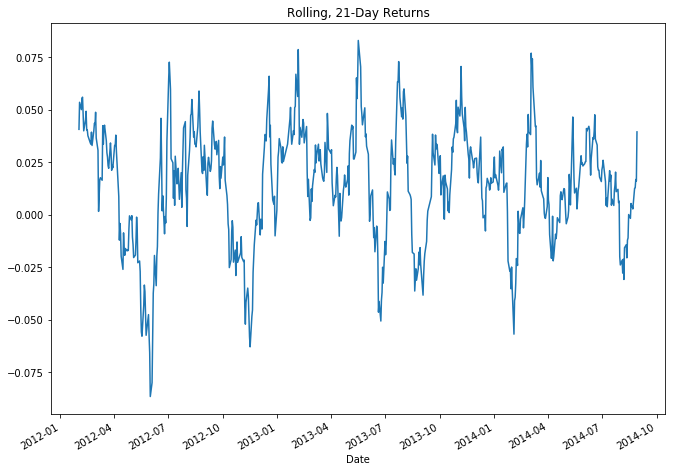

In [27]:
df_adjust["return_cumulative_21_day"] = df_adjust.return_daily_gross.dropna().rolling(21).apply(np.prod, raw=True) - 1

ax = df_adjust.return_cumulative_21_day.plot(figsize=(11, 8))
t = ax.title.set_text("Rolling, 21-Day Returns")

# Average 


In [28]:
df_adjust["return_mean_21_day"] = df_adjust.return_daily.rolling(21).mean()

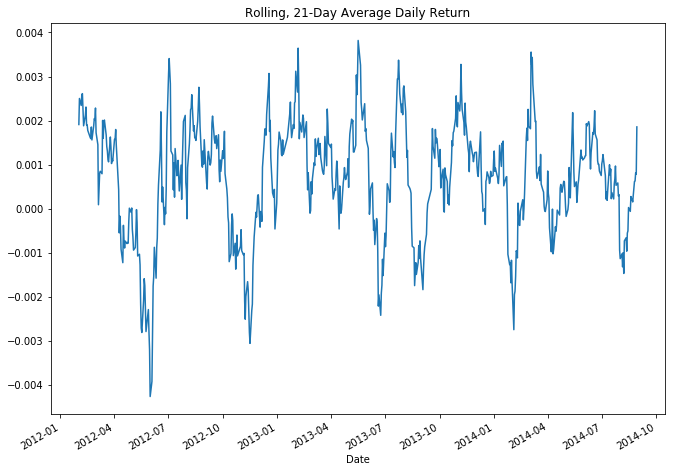

In [29]:
ax = df_adjust.return_mean_21_day.plot(figsize=(11, 8))
t = ax.title.set_text("Rolling, 21-Day Average Daily Return")


# Volatility

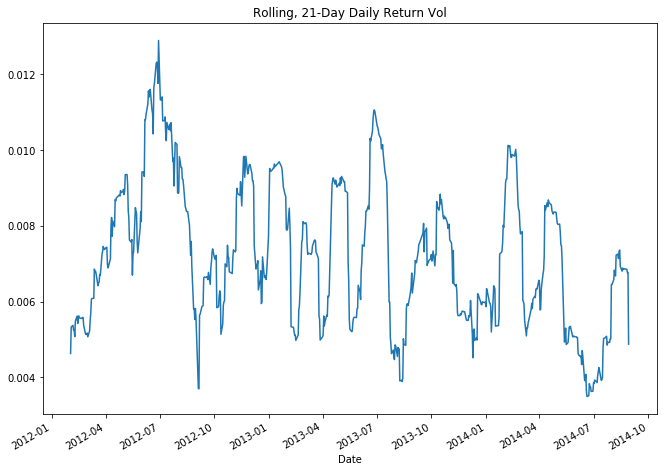

In [30]:
df_adjust["return_std_21_day"] = df_adjust.return_daily.rolling(21).std()

ax = df_adjust.return_std_21_day.plot(figsize=(11, 8))
t = ax.title.set_text("Rolling, 21-Day Daily Return Vol")

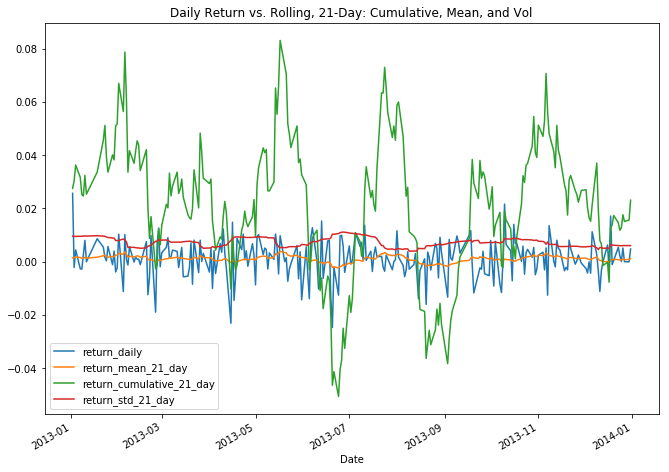

In [34]:
ax = df_adjust.loc[
    df_adjust.year == 2013,
    ["return_daily", "return_mean_21_day", "return_cumulative_21_day", "return_std_21_day"]
            ].plot(figsize=(11, 8))

t = ax.title.set_text("Daily Return vs. Rolling, 21-Day: Cumulative, Mean, and Vol")

In [77]:
train = df_adjust[:600]
test = df_adjust[600:]

df_adjust.shape, train.shape, test.shape

((663, 11), (600, 11), (63, 11))

In [78]:
df_adjust.head()

,Signal,ClosePrice,Z_score_price,return_daily,Z_score_return,year,month,return_daily_gross,return_cumulative_21_day,return_mean_21_day,return_std_21_day
Date,,,,,,,,,,,
2012-01-04,3.107282,127.70,-0.905270,0.001608,0.122425,2012,1,1.001608,NaN,NaN,NaN
2012-01-05,3.099757,128.04,-0.896592,0.002662,0.266454,2012,1,1.002662,NaN,NaN,NaN
2012-01-06,3.134223,127.71,-0.905015,-0.002577,-0.449165,2012,1,0.997423,NaN,NaN,NaN
2012-01-09,3.135922,128.02,-0.897103,0.002427,0.234343,2012,1,1.002427,NaN,NaN,NaN
2012-01-10,3.143447,129.13,-0.868773,0.008671,1.086990,2012,1,1.008671,NaN,NaN,NaN


In [91]:
reg = LinearRegression()

In [106]:
X_train = train['Signal'].values.reshape(1,-1)  # values converts it into a numpy array
Y_train = train['return_daily'].values.reshape(1,-1)

X_test = test['Signal'].values.reshape(1,-1)  
Y_test = test['return_daily'].values.reshape(1,-1)

X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((1, 600), (1, 600), (1, 63), (1, 63))

In [107]:
reg = reg.fit(X_train,Y_train)

In [110]:
X_test

array([[4.74708738, 4.73106796, 4.69757282, 4.7118932 , 4.7157767 ,
        4.72888349, 4.76347087, 4.76893204, 4.75582524, 4.75436893,
        4.72572815, 4.74708738, 4.74368932, 4.75291262, 4.75048544,
        4.78228155, 4.78713592, 4.81067961, 4.79393204, 4.78446602,
        4.77208738, 4.76553398, 4.7631068 , 4.7961165 , 4.78713592,
        4.80485437, 4.75024272, 4.79878398, 4.78980583, 4.81067961,
        4.82135922, 4.82160194, 4.79902913, 4.80097087, 4.78033981,
        4.78106796, 4.68665049, 4.6723301 , 4.70606796, 4.66043689,
        4.6618932 , 4.63665048, 4.70376214, 4.6973301 , 4.69029126,
        4.72912621, 4.75145631, 4.75048544, 4.79029126, 4.81529126,
        4.82815534, 4.84223301, 4.83470874, 4.8592233 , 4.86237864,
        4.86043689, 4.85776699, 4.87160194, 4.86917476, 4.86650485,
        4.85946845, 4.88131068, 4.86868932]])

In [109]:
Y_pred = reg.predict(X_test.dropna()) 


AttributeError: 'numpy.ndarray' object has no attribute 'dropna'

In [113]:
df_adjust.index[0]

Timestamp('2012-01-04 00:00:00')

In [118]:
model_obj = Ridge(alpha = 10**4)

X = df_adjust.Signal.values.reshape(1,-1) 

y = df_adjust.return_daily.values.reshape(1,-1) 

start_date = datetime.date(2012,1,4)

trial_width = 252

test_width = 5

num_trials = 50 

In [119]:
def time_series_validation(model_obj, X, y, start_date, trial_width, test_width, num_trials):
    
    results = []
    
    for i in range(num_trials):

        end_date = start_date + datetime.timedelta(days=trial_width)
        # now we have a window of [start_date, end_date] and we want train / test split
        
        test_start = end_date - datetime.timedelta(days=test_width)
        train_end = test_start - datetime.timedelta(days=1)
        
        print(start_date, train_end, test_start, end_date)
        
        # now, get train and test boundaries
        # split X and y into X_train, y_train, X_test, y_test based on train and test boundaries
        X_train = X.loc[start_date:train_end]
        X_test = X.loc[test_start:end_date]
        
        y_train = y.loc[start_date:train_end]
        y_test = y.loc[test_start:end_date]
        
        # train the model
        model_obj = model_obj.fit(X_train, y_train)
        y_pred = model_obj.predict(X_test)
        

        y_test = y_test.to_frame()
        y_test['y_pred'] = y_pred
        # save trial results
        results.append(y_test)
        start_date = start_date + datetime.timedelta(days=test_width +1)
    
    return results
        # now, bump start_date forward by test_width

In [120]:
time_series_validation(model_obj, X, y, start_date, trial_width, test_width, num_trials)

2012-01-04 2012-09-06 2012-09-07 2012-09-12


AttributeError: 'numpy.ndarray' object has no attribute 'loc'